In [1]:
import tensorflow as tf
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader.data as web
import scipy.optimize as opt
from scipy.optimize import minimize
from datetime import date
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, BatchNormalization
from collections import namedtuple
from FunctionsGANs import discriminator
from FunctionsGANs import generator
from FunctionsGANs import train_step
from FunctionsGANs import prepare_stock_data

In [2]:
x_train, x_test = prepare_stock_data('AAPL', '2014-11-01', '2024-11-17')

[*********************100%***********************]  1 of 1 completed


In [4]:
disc_model = discriminator()
disc_model.summary()

C:\Users\rania\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 252, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 252, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 252, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 252, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 252, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 252, 1)         │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,649 (108.00 KB)

 Trainable params: 27,649 (108.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
gen_model = generator()
gen_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 252)            │        64,764 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,828 (1.62 MB)

 Trainable params: 424,828 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#por la libreria de tf no me dejaba no incluirla
@tf.function
def train_step(data, batch_size = 100):
    noise = tf.random.normal([batch_size, 500])
    #for:
    #    ...
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = gen_model(noise, training = True)
        y_real = disc_model(data, training = True)
        y_fake = disc_model(generated_data, training = True)
    
        gen_loss = -tf.math.reduce_mean(y_fake)
        disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_real)
        
        
    gradients_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, disc_model.trainable_variables))
    
    return gen_loss, disc_loss

gen_model = generator()
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

gen_loss_history = []
disc_loss_history = []

num_batches = x_train.shape[0] // 200
for epoch in range(100):
    for i in tqdm.tqdm(range(num_batches)):
        batch = x_train[i*200:(1+i)*200]
        gen_loss, disc_loss = train_step(batch)

        gen_loss_history.append(gen_loss.numpy())
        disc_loss_history.append(disc_loss.numpy())

100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


C:\Users\rania\AppData\Local\Temp\ipykernel_18892\3456167039.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


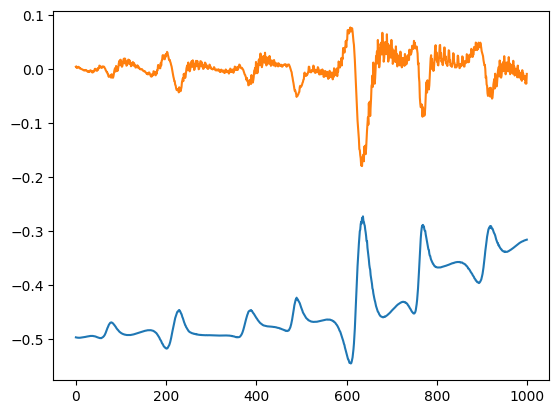

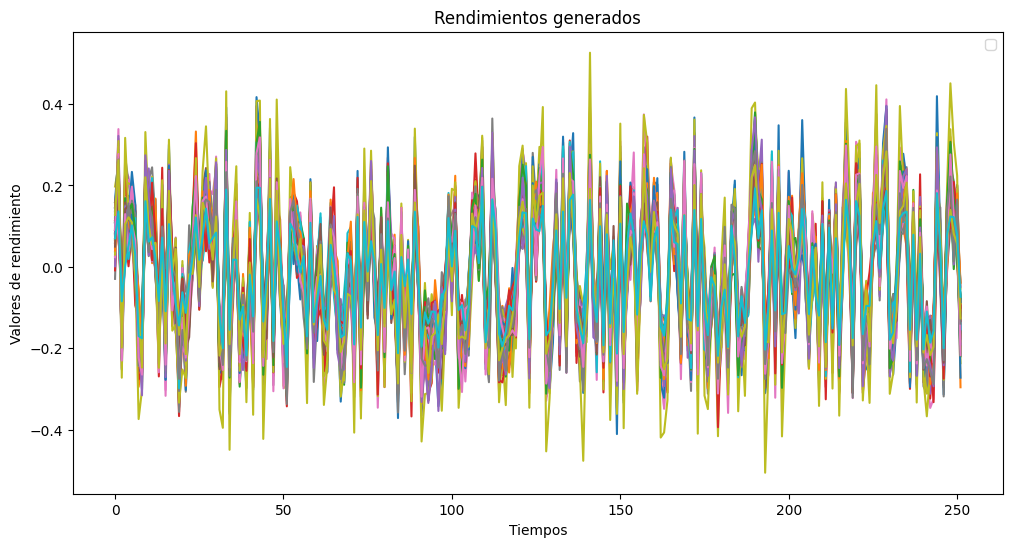

In [14]:
# Graficar pérdidas
plt.plot(gen_loss_history)
plt.plot(disc_loss_history)

# Generar series
noise = tf.random.normal([100, 500])  
generated_series = gen_model(noise, training=False)  

plt.figure(figsize=(12, 6))
for j in range(100):  
    plt.plot(generated_series[j, :])

plt.title("Rendimientos generados")
plt.xlabel("Tiempos")
plt.ylabel("Valores de rendimiento")
plt.legend()
plt.show()

In [17]:
np.save('noise.npy', noise)
np.save('generated_series.npy', generated_series)